In [ ]:
prova.Hidden_Output


In [ ]:
prova = BoltzamannMachine( nodes = 3 ,
             hidden_nodes = 3,
             out_nodes =3 ,
             learning_rate = 0.1)
prova.train([1,2,3],[1,2,3],3)

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import truncnorm 

In [2]:
class BoltzamannMachine:
    
    def __init__ ( self , nodes , hidden_nodes , out_nodes , learning_rate ):
        self.nodes = nodes
        self.hidden_nodes = hidden_nodes
        self.out_nodes = out_nodes
        self.learning_rate = learning_rate

        self.weight_matrix()
        self.LogErr = 0
        self.MSE = 0
        
    def weight_matrix(self):
    
        #set input-hidden matrix
        var = 1/np.sqrt(self.nodes)
        M = truncnorm(-var, var, loc = 0, scale = 1)
        self.Input_Hidden = M.rvs((self.hidden_nodes, self.nodes))
        
        #set hidden-output matrix
        var = 1/np.sqrt(self.hidden_nodes)
        M = truncnorm (-var, var, loc = 0, scale = 1)
        self.Hidden_Output = M.rvs((self.out_nodes, self.hidden_nodes))
        
    def train(self, input_, target, n):
        
        input_ = np.array(input_, ndmin = 2).T
        target = np.array(target, ndmin = 2).T
        
        sigma1 = sigma(np.dot(self.Input_Hidden, input_))
        sigma2 = sigma(np.dot(self.Hidden_Output, sigma1)) #output
        
        #estimate errors
        err = target - sigma2        
        self.MSE =(1/n) * (((sigma2 - target)**2).sum())
        self.LogErr = -(target * np.log(sigma2) + (np.repeat(1, n) - target) * np.log(np.repeat(1, n) - sigma2)).sum()
        
        #updating hidden-output matrix
        delta = err * dsigmaapprox(sigma2)
        self.Hidden_Output += self.learning_rate * np.dot(delta , sigma1.T)
        
        #updating input-hidden matrix
        err_hidden = np.dot(self.Hidden_Output.T, err)
        delta = err_hidden * dsigmaapprox(sigma1)
        self.Input_Hidden += self.learning_rate * np.dot(delta, input_.T)
        
    #calcola di nuovo la rete       
    def Pensa(self, input_):
        input_ = np.array(input_).T
        vettore_out = sigma(np.dot(self.Input_Hidden, input_))
        out = sigma(np.dot(self.Hidden_Output, vettore_out))
        return out
    
    def MatricediConfusione ( self , dati , etichetta ):
        MatConf = np.zeros ((10 ,10) , dtype =int)
        for i in range ( len ( dati )) :
            risposta = self.Pensa ( dati [i ])
            risposta_max = risposta.argmax () # indice del max sulla riga
            task = etichetta [i][0]
            MatConf [ risposta_max , int ( task )] += 1
        return MatConf

 # sulla diagonale vi sono il numero delle predizionicorrette

    def CalcoloPrecisione ( self , etichetta , MatConf ): 
        colonna = MatConf [: , etichetta ] # prendo la colonna riferita al label
        return MatConf [ etichetta , etichetta ]/ colonna.sum ()
          
#La precisione e' la percentuale delle previsionipositive
# corrette sul totale delle previsioni positive delmodello .
 # percisione_i := \ frac {M_{i,i }}{\ sum_j M_{j,i}}
 # cioe ' l'elemento i- esimo della diagonale fratto lasomma
 # degli elementi della colonna i- esima

    def CaloloRichiamo ( self , etichetta , MatConf ):
        riga = MatConf [ etichetta ,:] # prendo la riga riferita al label
        return MatConf [ etichetta , etichetta ]/ riga.sum()
 
 #Il richiamo e' la percentuale delle previsionipositive
 # corrette sul totale delle istanze positive .
 # richiamo_i := \ frac {M_{i,i }}{\ sum_j M_{ij }}
 # cioe ' e' l'elemento i- esimo della diagonale frattola somma
 # degli elementi della riga i- esima

 # Analizziamo i risultati e vediamo quale istanzesono corrette
 #e quali sono sbagliate , per avere una stima dell ' errore compuito .
    def Analisi ( self , dati , etichetta ) :
        giusto =0
        sbagliato =0
        for i in range ( len ( dati )) :
            risposta = self.Pensa ( dati [i ]) # processo il pattern i- esimo
            risposta_max = risposta.argmax ()
 # determino l'inidice dell 'elemento di modulo max
 #e controllo se per caso non sta sulla diagonale
 #in quel caso sara ' corretto , altrimenti sara 'sbagliato
            if risposta_max == etichetta [i ]:
                giusto += 1
            else :
                sbagliato += 1
        return giusto , sbagliato

    def Accuratezza ( self , MatConf ):
        somma_diagonale = MatConf.trace ()
        somma_totale = MatConf.sum ()
        return somma_diagonale / somma_totale
 # facciamo il rapporto tra la traccia della matrice ela somma di tutti
 # gli elementi : infatti sulla diagonale vi sono leistanze correttamente
 # riconosciute e abbianate .

In [3]:
train_data = pd.read_csv('mnist_train.csv', delimiter=',')
test_data = pd.read_csv('mnist_test.csv', delimiter=',')

In [4]:
def dsigmaapprox (x):
    return x *(1 - x)

def sigma (x):
    return 1/(1+ np.exp(-x))

In [5]:
 # *****************************************
# PREPROCESSAMENTO DATI DI TRAINING e TEST
dimensione_immagine = 28 # immaginte 28 x 28
numero_etichette = 10 # numero delle cifre 0 ,1 ,... ,9
pixel_immagine = dimensione_immagine * dimensione_immagine
# 784 ~ numero di colonne del test_data + 1 che e' la colonna del label



scala = 0.99 / 255 #i codici per pixel grigi vannoda 0 a 255
immagini_training = np.asfarray ( train_data )[: , 1:] *scala + 0.01
immagini_test = np.asfarray ( test_data )[: , 1:] *scala + 0.01
# prendiamo valori nella matrice tra (0 ,1] -> [0.1 ,1]
#e normalizziamo
label_training = np.asfarray ( train_data )[: , :1]
label_test = np.asfarray ( test_data )[: , :1]

# associamo ad ogni cifra un vettore della basecanonica
v= np.arange (10)
for etichetta in range (10) :
    ei =( v == etichetta ). astype ( np.int )
 # print (" Etichetta ", etichetta , " vettore ", ei)

# facciamo la stessa cosa sul vettore dei label memorizzato prima e
# togliamo sostiuiamo gli 0 - >0.01
tmp = np.arange ( numero_etichette )
etichette_training = ( tmp == label_training ).astype( np.float )
etichette_test =( tmp == label_test ).astype( np.float )

etichette_training [ etichette_training ==0]=0.01
etichette_test [ etichette_test ==0]=0.01

etichette_training [ etichette_training ==1]=1
etichette_test [ etichette_test ==1]=1



In [6]:
# ***********************************
 # CREAZIONE CLASSE della RETE
Arr_Nodi_Nascosti =20 +20* np.array ( range (5) ) # numerodi neuroni nascosti
Arr_Tasso_Apprendimento = 0.1 + 0.2* np.array ( range(5) )

ListaBM =[]
for i in range (5) :
    for j in range (5) :
        MacchinaBoltzmann = BoltzamannMachine ( pixel_immagine ,Arr_Nodi_Nascosti [ i],10 ,Arr_Tasso_Apprendimento [j ])
        ListaBM.append ( MacchinaBoltzmann )

 # ***************************************
 # Trasformo la lista in una matrice 5x5
 # per poterci lavorare sopra
          
L= ListaBM
L= np.asarray ( ListaBM )
L= np.split (L ,5 , axis =0)
L1 = np.stack (L)

# raccolgo i valori delgi errori a processo
#di allenamento compleato
MatErr = np.zeros ((5 ,5) )
MatLogErr = np.zeros ((5 ,5) )

 # raccolgo i valori delgi errori durante il processo
MatIterateMSE =[]
MatIterateLogErr =[]

AssembleMatriceConfusione =[] # Lista contentente Mat .Conf .
MatriceAccuratezze = np.zeros ((5 ,5) ) # Matrice delle accuratezze

In [8]:
%%time
for i in range (5) :
    for j in range (5) :
        Macchina = L1 [i ][ j]
        for k in range ( len ( immagini_training )):
            Macchina.train ( immagini_training [k], etichette_training [k ],10)
        MatErr [ i ][ j] = Macchina.MSE
        MatLogErr [ i ][ j] = Macchina.LogErr
        MC = Macchina.MatricediConfusione (immagini_training , label_training )
        AssembleMatriceConfusione.append ( MC )
        MatriceAccuratezze [ i ][ j] = Macchina.Accuratezza ( MC )

<ipython-input-4-e4254e3875ef>:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(-x))


Wall time: 5min 39s


In [9]:
AssembleMC = AssembleMatriceConfusione
AssembleMC = np.asarray ( AssembleMC )
AssembleMC = np.split ( AssembleMC ,5 , axis =0)
AssembleMC = np.stack ( AssembleMC )


In [10]:
import matplotlib . pyplot as plt

# ##########################
 # TEST RETE
NumTest = 20
Matrice_MSE_TEST =[]

for i in range (5) :
    for j in range (5) :
        BM = L1 [ i ][ j]
        Vett_MSE_Test =[]
        for k in range ( NumTest ): # faccio i primi 50 test per ogni par .
            out = BM.Pensa ( immagini_test[k])
            err = (1/10) *((( out - etichette_test [ k ])**2).sum () )
            Vett_MSE_Test.append ( err ) # vett 1 xrange
            Matrice_MSE_TEST.append ( np.asarray (
    Vett_MSE_Test , dtype = float ))

Matrice_MSE_TEST = np.asarray ( Matrice_MSE_TEST )
Matrice_MSE_TEST = np.split ( Matrice_MSE_TEST ,5 , axis =0)
Matrice_MSE_TEST = np.stack ( Matrice_MSE_TEST )

alpha = 1#int( input (" Scegli un valore per il tasso diapprendimento \ ntra {1 ,3 ,5 ,7 ,9}: "))
N= 20#int ( input (" Scegli il numero dei neuroni nascosti \ntra {20 ,40 ,60 ,80 ,100}: "))

if alpha == 1:
    alpha1 = 0
elif alpha == 3:
    alpha1 = 1
elif alpha == 5:
    alpha1 = 2
elif alpha == 7:
    alpha1 = 3
elif alpha == 9:
    alpha1 = 4

if N == 20:
    N1 = 0
                    
elif N == 40:
    N1 = 1
elif N == 60:
    N1 = 2
elif N == 80:
    N1 = 3
elif N == 100:
    N1 = 4


C:\Users\CASA-PC\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


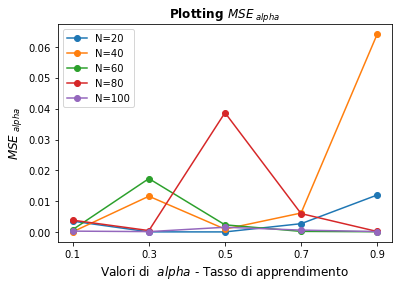

In [11]:
fig1 , ax1 = plt.subplots ()
for i in range (5) :
    ax1.plot ( MatErr [i], label ="N=%s" % (( i +1) *20) ,marker ='o')
plt.xticks ( np.arange (0 ,5 , step =1) ,
labels = np.array ([0.1 ,0.3 ,0.5 ,0.7 ,0.9]) )
plt.title (r'Plotting $MSE_ {\ alpha }$', fontsize ='large', fontweight ='bold')
plt.xlabel (r'Valori di $\ alpha$ - Tasso di apprendimento ', fontsize ='large')
plt.ylabel (r'$MSE_ {\ alpha }$', fontsize ='large')
plt.legend ()


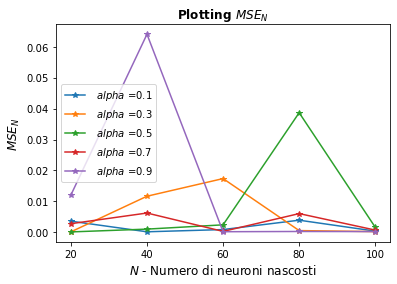

In [12]:
MatErr2 = MatErr.T
fig2 , ax2 = plt.subplots ()
for i in range (5) :
    ax2.plot ( MatErr2 [i], label =r'$\ alpha$ =%.2g' % ((2* i +1) *0.1) , marker ='*')
plt.xticks ( np.arange (0 ,5 , step =1) ,
labels = np.array ([20 ,40 ,60 ,80 ,100]) )
plt.title (r'Plotting $MSE_N$ ', fontsize ='large',fontweight ='bold')
plt.xlabel (r'$N$ - Numero di neuroni nascosti ', fontsize ='large')
plt.ylabel (r'$MSE_N$ ', fontsize ='large')
plt.legend ()

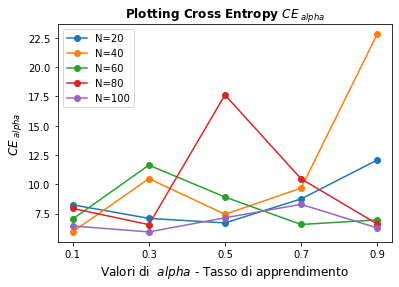

In [13]:
fig3 , ax3 = plt.subplots ()
for i in range (5) :
    ax3.plot ( MatLogErr [i ], label ="N=%s" % (( i +1) *20), marker ='o')
plt.xticks ( np.arange (0 ,5 , step =1) ,
labels = np.array([0.1 ,0.3 ,0.5 ,0.7 ,0.9]) )
plt.title (r'Plotting Cross Entropy $CE_ {\ alpha }$',fontsize ='large', fontweight ='bold')
plt.xlabel (r'Valori di $\ alpha$ - Tasso di apprendimento ', fontsize ='large')
plt.ylabel (r'$CE_ {\ alpha }$', fontsize ='large')
plt.legend ()

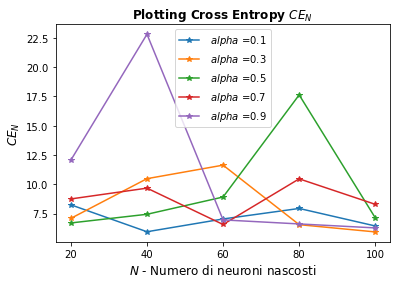

In [14]:
MatLogErr2 = MatLogErr.T
fig4 , ax4 = plt.subplots ()
for i in range (5) :
    ax4.plot ( MatLogErr2 [ i], label =r'$\ alpha$ =%.2g' %((2* i +1) *0.1) , marker ='*')
plt.xticks ( np.arange (0 ,5 , step =1) , np.array ([20 ,40 ,60 ,80 ,100]) )
plt.title (r'Plotting Cross Entropy $CE_N$ ', fontsize ='large', fontweight ='bold')
plt.xlabel (r'$N$ - Numero di neuroni nascosti ',fontsize ='large')
plt.ylabel (r'$CE_N$ ', fontsize ='large')
plt.legend ()

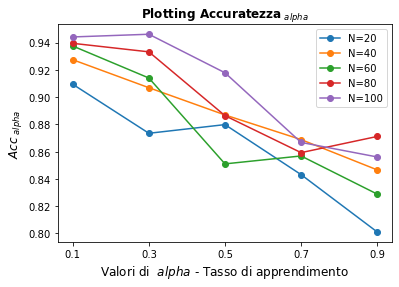

In [15]:
fig5 , ax5 = plt.subplots ()
for i in range (5) :
    ax5.plot ( MatriceAccuratezze [i ], label ="N=%s" %(( i +1) *20) , marker ='o')
plt.xticks ( np.arange (0 ,5 , step =1) ,
labels = np.array([0.1 ,0.3 ,0.5 ,0.7 ,0.9]) )
plt.title (r'Plotting Accuratezza$_ {\ alpha }$',fontsize ='large', fontweight ='bold')
plt.xlabel (r'Valori di $\ alpha$ - Tasso di apprendimento ', fontsize ='large')
plt.ylabel (r'$Acc_ {\ alpha }$', fontsize ='large')
plt.legend ()

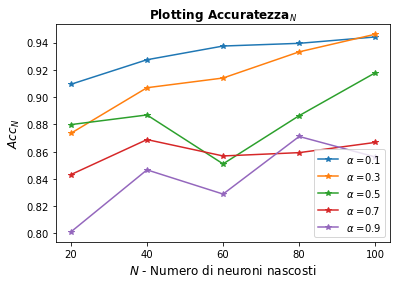

In [16]:
MatriceAccuratezze2 = MatriceAccuratezze .T
fig6 , ax6 = plt.subplots ()
for i in range (5) :
    ax6.plot ( MatriceAccuratezze2 [ i], label =r'$\alpha$ =%.2g' % ((2* i +1) *0.1) , marker ='*')
plt.xticks ( np.arange (0 ,5 , step =1) ,
np.array ([20 ,40 ,60 ,80 ,100]) )
plt.title (r'Plotting Accuratezza$_N$ ', fontsize ='large', fontweight ='bold')
plt.xlabel (r'$N$ - Numero di neuroni nascosti ',fontsize ='large')
plt.ylabel (r'$Acc_N$ ', fontsize ='large')
plt.legend ()

Text(0, 0.5, '$MSE$ ')

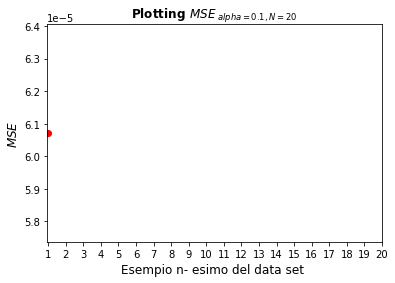

In [17]:
alpha = alpha *0.1
fig7 , ax7 = plt.subplots ()
ax7.plot ( Matrice_MSE_TEST [ N1 ][ alpha1 ], marker ='o',color ='r')
plt.xticks ( np.arange (0 , NumTest , step =1) , np.arange(20) +1)
plt.title (r'Plotting $MSE_ {\ alpha =%s,N=%s}$' %( alpha,N) , fontsize ='large',fontweight ='bold')
plt.xlabel (r'Esempio n- esimo del data set ', fontsize='large')
plt.ylabel (r'$MSE$ ', fontsize ='large')

In [ ]:
 # #### ALTRE VISUALIZZAZIONI ERRORI #####
B1 = ListaBM [20]
E =[]
v_err =[]
t_err =[]
for k in range (10) :
    for i in range ( len ( immagini_training )):
        B1.train ( immagini_training [i ],etichette_training [i ],10)
    E. append ( B1.MatricediConfusione (immagini_training , label_training ))
    t_err.append (1 - B1.Accuratezza (E[k ]) )
    v_err.append ( B1.MSE )

v_err = np.asarray ( v_err )
t_err = np.asarray ( t_err )
x= np.arange (0 ,10 , step =1)
fig8 , ax8 = plt.subplots ()
ax8.plot (x , v_err , label =r'$MSE_ {%.2g, %s}$' % (alpha , N) , marker ='o', color ='r')
ax8.plot (x , t_err , label =r'$\ mathrm {acc}_ {%.2g ,%s}$'% ( alpha ,N) , marker ='*')
plt.xticks ( np.arange (0 ,10 , step =1) , np.arange (10) +1) 
titolo =(r'$MSE_ {\ alpha =%s,N=%s}$ e accuratezza per10 training ses .' %( alpha ,N))
plt.title ( titolo , fontsize ='large', fontweight ='bold')
plt.xlabel (r'Sessione n- esima ', fontsize ='large')
plt.ylabel (r'$MSE$ \ $\ mathrm { acc}$', fontsize ='large')
plt.legend ()

In [ ]:
i = 2
etichette_test[i].argmax()

In [ ]:
BM = L1 [ 0 ][ 0]
x = BM.Pensa(immagini_test[i])
x

In [ ]:
x.argmax()